In [1]:
# Import sparksession
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp") .master("local[*]").getOrCreate()


In [2]:
spark

### Define the schema for loading the Chicago crime dataset (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data).

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType

# Define the schema for the Chicago crime dataset
crime_schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("CaseNumber", StringType(), True),
    StructField("Date", TimestampType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("PrimaryType", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("LocationDescription", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("CommunityArea", StringType(), True),
    StructField("FBICode", StringType(), True),
    StructField("XCoordinate", DoubleType(), True),
    StructField("YCoordinate", DoubleType(), True),
    StructField("Year", IntegerType(), True),
    StructField("UpdatedOn", TimestampType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])


### Load the Chicago crime data (you should get more than a million rows).


In [4]:
# Load the Chicago crime dataset 
crime_data = spark.read.csv(r"Crimes_-_2001_to_Present.csv", header=True, inferSchema=True)

crime_data.printSchema()
crime_data.show(5)


root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

+--------+-----------+--------------------+--------------------+----+------------------+--------

In [5]:
total_rows = crime_data.count()
print("Total rows in DataFrame:", total_rows)


Total rows in DataFrame: 8024810


### Clean the data:
i) Remove all null values.
ii) Change 'Date' column data type

In [6]:
# Remove all rows with null values
crime_data = crime_data.na.drop()

crime_data.show()


+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12045583|   JD226426|05/07/2020 10:24:...| 035XX S INDIANA AVE|0820|               THEFT|      $500 AND UNDER|           AP

In [7]:
from pyspark.sql.functions import col, to_timestamp

# Assuming your DataFrame is named crime_data

# Convert 'Date' column to TimestampType with the specified format
crime_data_with_timestamp = crime_data.withColumn("Date", to_timestamp(col("Date"), 'M/d/yyyy h:mm:ss a'))

crime_data_with_timestamp.show()


+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12045583|   JD226426|2020-05-07 10:24:00| 035XX S INDIANA AVE|0820|               THEFT|      $500 AND UNDER|           APARTM

In [8]:
total_rows = crime_data.count()
print("Total rows in DataFrame:", total_rows)


Total rows in DataFrame: 7321551


### Filter the data for last ten years.


In [9]:
import datetime 
current_year = datetime.datetime.now().year

# Calculate the starting year for the last 10 years
start_year_last_10_years = current_year - 10

# Filter rows for the last 10 years based on the "Year" column
crime_data_last_10_years = crime_data.filter((crime_data["Year"] >= start_year_last_10_years) & (crime_data["Year"] <= current_year))

crime_data_last_10_years.show(5)


+--------+-----------+--------------------+-------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|              Block|IUCR|     Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+-------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12045583|   JD226426|05/07/2020 10:24:...|035XX S INDIANA AVE|0820|            THEFT|      $500 AND UNDER|           APARTMENT| false| 

In [10]:
total_rows = crime_data_last_10_years.count()
print("Total rows in DataFrame:", total_rows)


Total rows in DataFrame: 2534993


### Remove all the records with the following crime types:
'NON-CRIMINAL (SUBJECT SPECIFIED)'
'OTHER OFFENSE'
'STALKING'
'NON - CRIMINAL'
'ARSON'

In [11]:
from pyspark.sql.functions import col

# List of crime types to remove
crime_types_to_remove = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']

# Filter the data to remove records with specified crime types
filtered_crime_data = crime_data_last_10_years.filter(~col("Primary Type").isin(crime_types_to_remove))

filtered_crime_data.show(5)


+--------+-----------+--------------------+-------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|              Block|IUCR|     Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+-------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12045583|   JD226426|05/07/2020 10:24:...|035XX S INDIANA AVE|0820|            THEFT|      $500 AND UNDER|           APARTMENT| false| 

In [12]:
total_rows = filtered_crime_data.count()
print("Total rows in DataFrame:", total_rows)


Total rows in DataFrame: 2366202


### Merge the similar crime types.
For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.

In [13]:
from pyspark.sql.functions import col, when

# Merge similar crime types
crime_data_merged = filtered_crime_data.withColumn("Primary Type",
                        when((col("Primary Type") == "CRIM SEXUAL ASSAULT") | (col("Primary Type") == "SEX OFFENSE"), "SEXUAL_CRIMES")
                        .when((col("Primary Type") == "NARCOTICS") | (col("Primary Type") == "OTHER NARCOTIC VIOLATION"), "DRUG VIOLATION")
                        # Add more conditions here to merge other similar types
                        .otherwise(col("Primary Type")))

crime_data_merged.show(5)


+--------+-----------+--------------------+-------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|              Block|IUCR|     Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+-------------------+----+-----------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12045583|   JD226426|05/07/2020 10:24:...|035XX S INDIANA AVE|0820|            THEFT|      $500 AND UNDER|           APARTMENT| false| 

### Analyze the data and present results:
A) Show year-wise trend of the crime for last ten years.

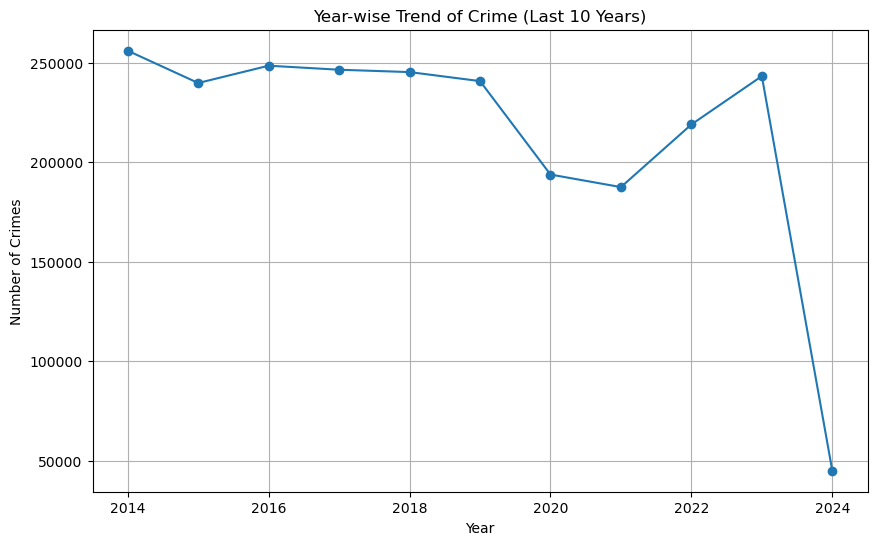

In [14]:
import datetime 
current_year = datetime.datetime.now().year
start_year_last_10_years = current_year - 10
filtered_crime_data = crime_data_merged.filter(col("Year") >= start_year_last_10_years)

# Group data by year and count the number of crimes
crime_count_by_year = filtered_crime_data.groupBy("Year").count().orderBy("Year")

crime_count_by_year_df = crime_count_by_year.toPandas()

# Plot the year-wise trend of crime
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(crime_count_by_year_df["Year"], crime_count_by_year_df["count"], marker='o', linestyle='-')
plt.title("Year-wise Trend of Crime (Last 10 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.show()


B) Find out at which hour of the day crime is highest.

In [15]:
from pyspark.sql.functions import hour


# Extract hour from the "Date" column
crime_data_with_hour = crime_data_with_timestamp.withColumn("Hour", hour("Date"))

# Group data by hour and count the number of crimes
crime_count_by_hour = crime_data_with_hour.groupBy("Hour").count().orderBy("count", ascending=False)

# Show the hour with the highest crime count
highest_crime_hour = crime_count_by_hour.first()["Hour"]

print("Hour of the day with the highest crime count:", highest_crime_hour)


Hour of the day with the highest crime count: 12


### C. Find top ten crimes and present them as a bar chart.


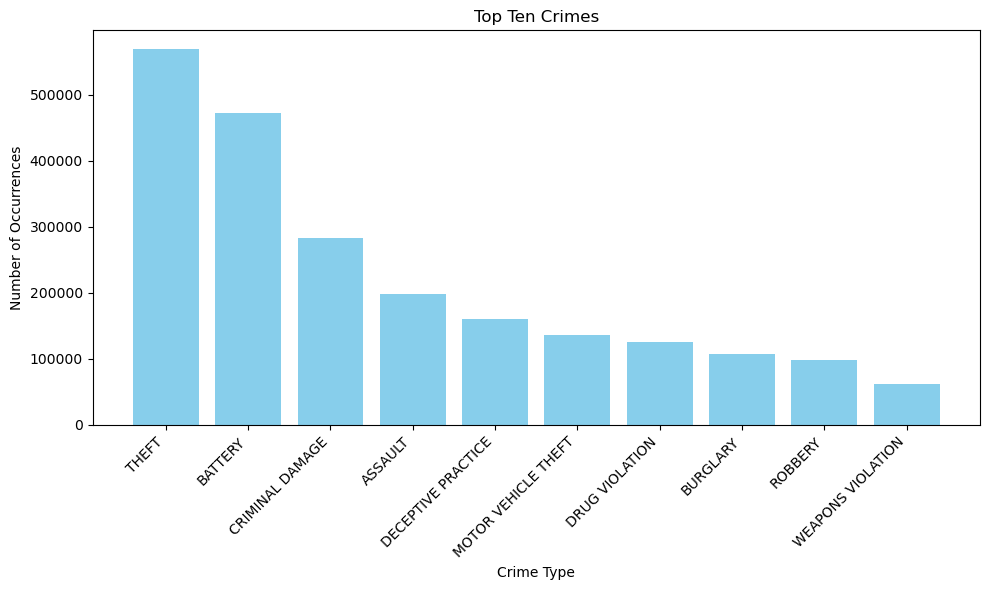

In [16]:
import matplotlib.pyplot as plt


# Group data by "Primary Type" and count the occurrences of each crime type
crime_count_by_type = crime_data_merged.groupBy("Primary Type").count()

# Sort the result by count in descending order and select the top ten crime types
top_ten_crimes = crime_count_by_type.orderBy("count", ascending=False).limit(10)

top_ten_crimes_pd = top_ten_crimes.toPandas()

# Plot top ten crimes as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_ten_crimes_pd["Primary Type"], top_ten_crimes_pd["count"], color='skyblue')
plt.title("Top Ten Crimes")
plt.xlabel("Crime Type")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
